# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов:

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
!pip install -q tensorflow==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.1


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.7.0


# Загружаем данные

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

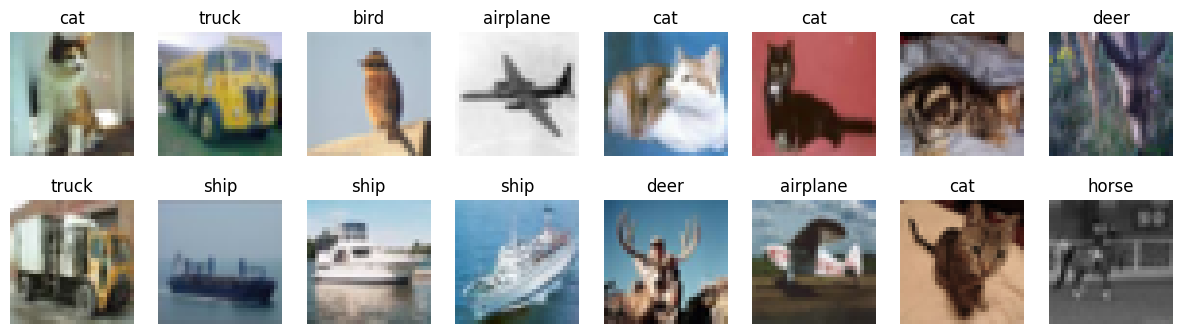

In [6]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [7]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [8]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе;
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [9]:
def make_default_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='relu'))
    return model

In [10]:
K.clear_session()
model = make_default_model()
model.summary()

c:\Project\lessons\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,234 (4.14 MB)

 Trainable params: 1,084,234 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

# Тренируем модель

In [11]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )

  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [12]:
# учим дефолтную архитектуру
train_model()

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.2014 - loss: 2.5741 - val_accuracy: 0.2057 - val_loss: 2.1218
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.2474 - loss: 2.1603 - val_accuracy: 0.3394 - val_loss: 1.9365
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.3511 - loss: 1.9403 - val_accuracy: 0.3173 - val_loss: 2.0248
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.2814 - loss: 2.0661 - val_accuracy: 0.3243 - val_loss: 1.9944
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.2839 - loss: 2.0348 - val_accuracy: 0.3914 - val_loss: 1.7874
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.3482 - loss: 1.9325 - val_accuracy: 0.3333 - val_loss: 1.9929
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.3447 - loss: 1.9489 - val_accuracy: 0.4166 - val_loss: 1.7287
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.3535 -

<Sequential name=sequential, built=True>

In [13]:
def make_sigmoid_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='sigmoid'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='sigmoid'))
    return model

In [14]:
# учим sigmoid
train_model(make_sigmoid_model)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - accuracy: 0.4097 - loss: 1.6519 - val_accuracy: 0.6192 - val_loss: 1.0688
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5993 - loss: 1.1415 - val_accuracy: 0.6586 - val_loss: 0.9767
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.6344 - loss: 1.0549 - val_accuracy: 0.6772 - val_loss: 0.9324
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.6438 - loss: 1.0190 - val_accuracy: 0.6763 - val_loss: 0.9268
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.6433 - loss: 1.0162 - val_accuracy: 0.6858 - val_loss: 0.8999
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.6493 - loss: 1.0067 - val_accuracy: 0.6850 - val_loss: 0.9025
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.6476 - loss: 1.0082 - val_accuracy: 0.6831 - val_loss: 0.9137
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6434 -

<Sequential name=sequential, built=True>

In [15]:
# учим sgd
train_model(optimizer="sgd")

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.1230 - loss: 2.5151 - val_accuracy: 0.1913 - val_loss: 2.2361
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.1555 - loss: 2.2496 - val_accuracy: 0.2060 - val_loss: 2.1642
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.1877 - loss: 2.1735 - val_accuracy: 0.2155 - val_loss: 2.0966
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.2003 - loss: 2.1284 - val_accuracy: 0.2757 - val_loss: 2.0310
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.1188 - loss: 2.3469 - val_accuracy: 0.1624 - val_loss: 2.2465
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.1723 - loss: 2.2268 - val_accuracy: 0.2318 - val_loss: 2.1062
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.2072 - loss: 2.1382 - val_accuracy: 0.1283 - val_loss: 2.2696
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.1604 -

<Sequential name=sequential, built=True>

In [16]:
def make_bn_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(BatchNormalization())    
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='relu'))
    return model


In [17]:
# учим bn
train_model(make_bn_model)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 43ms/step - accuracy: 0.2286 - loss: 4.3216 - val_accuracy: 0.2829 - val_loss: 2.7434
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.2287 - loss: 3.0108 - val_accuracy: 0.2683 - val_loss: 2.3725
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.2362 - loss: 2.5143 - val_accuracy: 0.3109 - val_loss: 2.1362
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.1846 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.0996 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.0996 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.0996 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.0996 - loss: nan - val_accurac

<Sequential name=sequential, built=True>

In [18]:
def make_sigmoid_bn_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='sigmoid'))
    model.add(BatchNormalization())    
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='sigmoid'))
    return model

In [19]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step - accuracy: 0.3792 - loss: 1.8294 - val_accuracy: 0.5794 - val_loss: 1.2132
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.5632 - loss: 1.2518 - val_accuracy: 0.6217 - val_loss: 1.0840
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.6028 - loss: 1.1407 - val_accuracy: 0.6396 - val_loss: 1.0324
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.6210 - loss: 1.0878 - val_accuracy: 0.6634 - val_loss: 0.9652
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6382 - loss: 1.0357 - val_accuracy: 0.6759 - val_loss: 0.9430
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6573 - loss: 0.9972 - val_accuracy: 0.6892 - val_loss: 0.8818
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.6662 - loss: 0.9656 - val_accuracy: 0.6955 - val_loss: 0.8864
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.6766 -

<Sequential name=sequential, built=True>